<a href="https://colab.research.google.com/github/smolinad/quantum_machine_learning/blob/main/QSVM_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sergio Quiroga Sandoval \
squirogas@unal.edu.co



The following is a reproduced implementation of the paper quantum enhanced feature learning first model (QSVC), a modified version of Quiskit documentation.
Using the AD-HOC dataset


Fundamental concepts:


*   Kernel, kernel matrix.
*   Quantum kernel.  https://www.youtube.com/watch?v=m6EzmYsEOiI
*   ZZ feature map. https://www.youtube.com/watch?v=zw3JYUrS-v8
*   Precomputed kernel matrix.



###Reproducibility

In [1]:
!pip install qiskit_machine_learning
!pip install qiskit-algorithms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 10.1 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512379 sha256=dea8891e5b21ac0fdfd0b2620eade71cc38ae3b307e3e0e3c4d86b0f3bb78cc1
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448da

### For importing and plotting the dataset

In [2]:
#Import the dataset, define train and test subsets
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit.utils import algorithm_globals  #Using the same qiskit seed for cheking results
algorithm_globals.random_seed = 12345

adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

In [3]:
#code for plotting the chosen dataset
import matplotlib.pyplot as plt
import numpy as np


def plot_features(ax, features, labels, class_label, marker, face, edge, label):
    # A train plot
    ax.scatter(
        # x coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 0],
        # y coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 1],
        marker=marker,
        facecolors=face,
        edgecolors=edge,
        label=label,
    )


def plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total):

    plt.figure(figsize=(5, 5))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)
    plt.imshow(
        np.asmatrix(adhoc_total).T,
        interpolation="nearest",
        origin="lower",
        cmap="RdBu",
        extent=[0, 2 * np.pi, 0, 2 * np.pi],
    )

    # A train plot
    plot_features(plt, train_features, train_labels, 0, "s", "w", "b", "A train")

    # B train plot
    plot_features(plt, train_features, train_labels, 1, "o", "w", "r", "B train")

    # A test plot
    plot_features(plt, test_features, test_labels, 0, "s", "b", "w", "A test")

    # B test plot
    plot_features(plt, test_features, test_labels, 1, "o", "r", "w", "B test")

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title("Ad hoc dataset")

    plt.show()

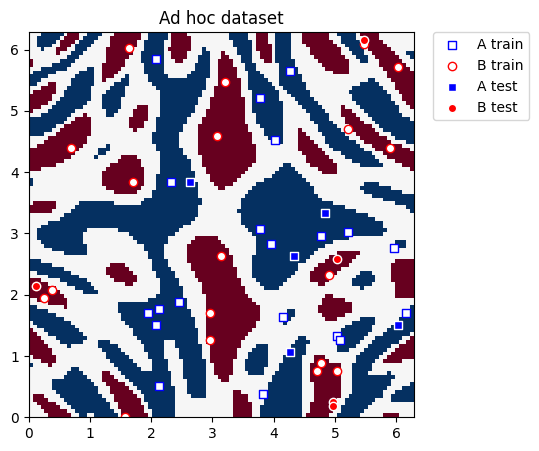

In [4]:
plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total)


#Quantum Support Vector Classifier

**Feature map**: Data cannot typically be separated by a hyperplane in its original space. A common technique used to find such a hyperplane consists of applying a non-linear transformation function to the data. This function is called a , as it transforms the raw features, or measurable properties, of the phenomenon or subject under study.\

**Classifying**  in this new feature space and, also in any other space, including the raw original one- is nothing more than seeing **how close data points are** to each other. This is the same as computing the inner product for each pair of data points in the set. So, in fact we do not need to compute the non-linear feature map for each datum, but only the inner product of each pair of data points in the new feature space.\

 **Quantum kernel**:   The collection of inner products is called the kernel and it is perfectly possible to have feature maps that are hard to compute but whose kernels are not." - Qiskit

In [5]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear") #what does entanglement="linear" mean?

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

<ipython-input-5-03a955d35ad8>:3: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.state_fidelities import ComputeUncompute


In [6]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=adhoc_kernel)

qsvc.fit(train_features, train_labels)

qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 1.0


### SVC using kernel as a callable function

adhoc_kernel.evaluate

In [7]:
from sklearn.svm import SVC

adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)

adhoc_svc.fit(train_features, train_labels)

adhoc_score_callable_function = adhoc_svc.score(test_features, test_labels)

print(f"Callable kernel classification test score: {adhoc_score_callable_function}")

Callable kernel classification test score: 1.0


### SVC using Precomputed Kernel matrix

"Instead of passing a function of the quantum kernel as a callable, we can also precompute training and testing kernel matrices before passing them to the scikit-learn SVC algorithm."

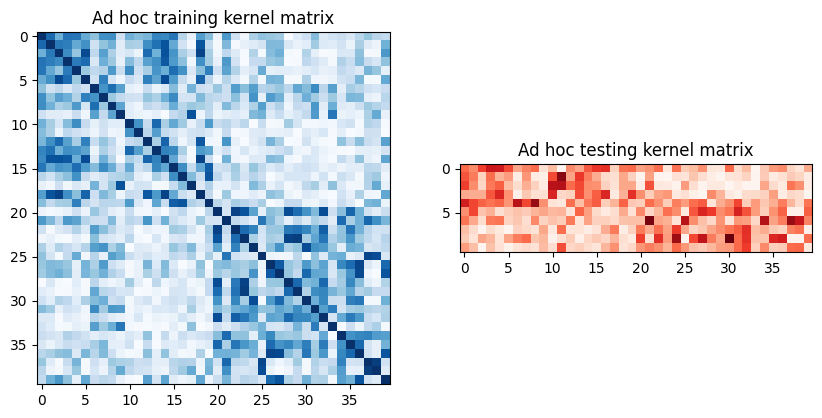

In [8]:
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(adhoc_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")

axs[1].imshow(np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")

plt.show()

"To use these matrices, we set the kernel parameter of a new SVC instance to "precomputed". We train the classifier by calling fit with the training matrix and training dataset. Once the model is trained, we evaluate it using the test matrix on the test dataset."

In [9]:
adhoc_svc = SVC(kernel="precomputed")

adhoc_svc.fit(adhoc_matrix_train, train_labels)

adhoc_score_precomputed_kernel = adhoc_svc.score(adhoc_matrix_test, test_labels)

print(f"Precomputed kernel classification test score: {adhoc_score_precomputed_kernel}")

Precomputed kernel classification test score: 1.0


### Evaluation of the three models

In [10]:
print(f"Classification Model                    | Accuracy Score")
print(f"---------------------------------------------------------")
print(f"SVC using kernel as a callable function | {adhoc_score_callable_function:10.2f}")
print(f"SVC using precomputed kernel matrix     | {adhoc_score_precomputed_kernel:10.2f}")
print(f"QSVC                                    | {qsvc_score:10.2f}")

Classification Model                    | Accuracy Score
---------------------------------------------------------
SVC using kernel as a callable function |       1.00
SVC using precomputed kernel matrix     |       1.00
QSVC                                    |       1.00


This code is a part of Qiskit
© Copyright IBM 2017, 2023.

This code is licensed under the Apache License, Version 2.0. You may
obtain a copy of this license in the LICENSE.txt file in the root directory
of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.

Any modifications or derivative works of this code must retain this
copyright notice, and modified files need to carry a notice indicating
that they have been altered from the originals.

(this code has been altered)

# Moons dataset

In [11]:
from sklearn.datasets import make_moons
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from time import time
import numpy as np
import pylab as pl
#--------------------------------------------------
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
import qiskit_algorithms
from qiskit_machine_learning.kernels import FidelityQuantumKernel
#---------------------------------QSVC
from qiskit_machine_learning.algorithms import QSVC

In [12]:

# Function to visualize a 2D dataset
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

# Function to visualize the decission surface of a classifier
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 50)
    y_vals = np.linspace(min_y, max_y, 50)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    vals = [[XX[i, j], YY[i, j]] for i in range(grid_r) for j in range(grid_c)]
    preds = pred_fun(np.array(vals))
    ZZ = np.reshape(preds, (grid_r, grid_c))
    print(np.min(preds), np.min(ZZ))
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= 0, vmax=1)
    pl.colorbar()
    CS = pl.contour(XX, YY, ZZ, 100, levels = [0.1*i for i in range(1,10)])
    pl.clabel(CS, inline=1, fontsize=10)
    pl.xlabel("x")
    pl.ylabel("y")

def gen_pred_fun(clf):
    def pred_fun(X):
        return clf.predict(X)[:, 1]
    return pred_fun

In [13]:
''' codigo antiguo para entrenar el modelo con moons dataset, se cambió por los siguientes bloques
X, y = make_moons(n_samples=200, noise=0.2, random_state=0) #originalmente 2000 samples
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42)
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]'''

' codigo antiguo para entrenar el modelo con moons dataset, se cambió por los siguientes bloques\nX, y = make_moons(n_samples=200, noise=0.2, random_state=0) #originalmente 2000 samples\nscaler = MinMaxScaler()\nX = scaler.fit_transform(X)\nX_train, X_test, y_train, y_test = train_test_split(\n        X, y, test_size=0.1, random_state=42)\ny_train = y_train[:, np.newaxis]\ny_test = y_test[:, np.newaxis]'

##QSVM in qiskit for Mooons

In [14]:
!gdown 1-ZsQLdWlngc_Tj6DwB0erS3u7lKgTr4E
!gdown 1-Y9ppUUbkSlibAuEk38230fMCCN4sGYk
!gdown 1-WG8wEuqSyCwKK8fuTvy-no0F9dnLSzL
!gdown 1-VVmEfuJSiK28bPwBxRbybzLiIUPwTYA
!gdown 1-UwiZGwUduS1p9bEz75wXRYvoSlZqcwa
!gdown 1-Qq5pqzhWsI6RZIVUnvqHB1qgzapBMEq
!gdown 1-Osd7V04MgICHH0_g881gC7L5_P7JGlb
!gdown 1-MI24TzwQQsoeX_qWOTKyAvOCRG9MBMa

Downloading...
From: https://drive.google.com/uc?id=1-ZsQLdWlngc_Tj6DwB0erS3u7lKgTr4E
To: /content/MoonsQMC_gamma32_4classqaff_mixed_average_Xtrain_190923.npy
100% 14.5k/14.5k [00:00<00:00, 45.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-Y9ppUUbkSlibAuEk38230fMCCN4sGYk
To: /content/MoonsQMC_gamma32_4classqaff_mixed_average_Xtest_190923.npy
100% 1.73k/1.73k [00:00<00:00, 8.27MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-WG8wEuqSyCwKK8fuTvy-no0F9dnLSzL
To: /content/MoonsQMC_gamma32_4classqaff_mixed_average_Xgrid_190923.npy
100% 6.53k/6.53k [00:00<00:00, 23.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-VVmEfuJSiK28bPwBxRbybzLiIUPwTYA
To: /content/MoonsQMC_gamma32_4classqaff_mixed_average_X_qaff_train_190923.npy
100% 57.7k/57.7k [00:00<00:00, 101MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-UwiZGwUduS1p9bEz75wXRYvoSlZqcwa
To: /content/MoonsQMC_gamma32_4classqaff_mixed_average_X_qaff_test_190923.npy
100% 6.53k/6.53k [00:00<00:00, 23

In [15]:
# upload features

X_train = np.load("/content/MoonsQMC_gamma32_4classqaff_mixed_average_Xtrain_190923.npy")
X_test = np.load("/content/MoonsQMC_gamma32_4classqaff_mixed_average_Xtest_190923.npy")
X_grid = np.load("/content/MoonsQMC_gamma32_4classqaff_mixed_average_Xgrid_190923.npy").reshape((20, 20, 2))[::2, ::2, :].reshape(100, 2)
X_feat_train = np.load("/content/MoonsQMC_gamma32_4classqaff_mixed_average_X_qaff_train_190923.npy")
X_feat_test = np.load("/content/MoonsQMC_gamma32_4classqaff_mixed_average_X_qaff_test_190923.npy")
X_feat_grid = np.load("/content/MoonsQMC_gamma32_4classqaff_mixed_average_X_qaff_grid_190923.npy").reshape((20, 20, 4))[::2, ::2, :].reshape(100, 4)

## upload targets and predictions

y_train = np.load("/content/MoonsQMC_gamma32_4classqaff_mixed_average_Ytrain_190923.npy")
y_test = np.load("/content/MoonsQMC_gamma32_4classqaff_mixed_average_Ytest_190923.npy")

X_train.shape, X_test.shape, X_grid.shape, X_feat_train.shape, X_feat_test.shape, X_feat_grid.shape, y_train.shape, y_test.shape

((900, 2),
 (100, 2),
 (100, 2),
 (900, 4),
 (100, 4),
 (100, 4),
 (900, 1),
 (100, 1))

In [16]:
#Defining the kernel

adhoc_feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement="linear") #what does entanglement="linear" mean?

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

#ZZFeatureMap.num_qubits

#adhoc_feature_map.num_qubits

In [17]:
# fitting and testing QSVC with adhoc_kernel
qsvc = QSVC(quantum_kernel=adhoc_kernel)

qsvc.fit(X_train, y_train)                                 # Cambié x_train, y_train a los de moons

qsvc_score = qsvc.score(X_test, y_test)                    # Cambié x_test, y_test a los de moons

print(f"QSVC classification test score: {qsvc_score}")

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


QSVC classification test score: 0.92


## Resultados:


*   Con 50 samples: 0.8 test score
*   con 100 samples: 0.7 test score
*   Con 200 samples: 0.9 test score  (1min30s)
*   con 500 samples: 0.92 test score  
*   con 800 samples: 0.96
*   con 1000 samples: 0.92 (50 mins)





<ipython-input-12-0105d83ec711>:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,


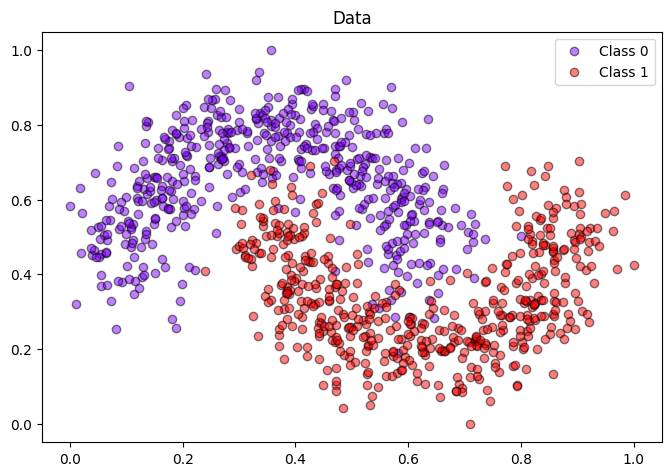

In [20]:
pl.figure(figsize = (8,16/3))
plot_data(np.concatenate([X_train, X_test]), np.concatenate([y_train, y_test]).ravel())

In [ ]:
pl.figure(figsize = (8,16/3))
plot_decision_region(np.concatenate([X_train, X_test]),gen_pred_fun(qsvc))
plot_data(np.concatenate([X_train, X_test]), np.concatenate([y_train, y_test]).ravel())


Aún no logro correr la gráfica del "decision region".